In [24]:
import os
import json
from time import time

import mplhep as hep

import matplotlib.pyplot as plt

hep.style.use("CMS")
plt.rcParams["figure.dpi"] = 400

In [25]:
import pandas as pd

start_time = time()
df = pd.read_parquet("./preprocessed_data/processed_data_1M.parquet")
print(f"Loaded data with {len(df)} samples and {len(df.columns)} features")

Loaded data with 1000000 samples and 68 features


In [26]:
seed = 42

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

# Prepare features and target
exclude_cols = ["HH", "bkg", "weight", "event_no"]
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].values
y = df["HH"].values
weights = df["weight"].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=seed, stratify=y
)



In [28]:
transformer_inputs = {
    "lepton_1": ["l1_Px", "l1_Py", "l1_Pz", "l1_E", "l1_pdgId", "l1_charge"],
    "lepton_2": ["l2_Px", "l2_Py", "l2_Pz", "l2_E", "l2_pdgId", "l2_charge"],
    "jet_1": ["j1_Px", "j1_Py", "j1_Pz", "j1_E", "j1_btag"],
    "jet_2": ["j2_Px", "j2_Py", "j2_Pz", "j2_E", "j2_btag"],
    "jet_3": ["j3_Px", "j3_Py", "j3_Pz", "j3_E", "j3_btag"],
    "jet_4": ["j4_Px", "j4_Py", "j4_Pz", "j4_E", "j4_btag"],
    "jet_8": ["j8_Px", "j8_Py", "j8_Pz", "j8_E", "j8_btag"],
    "met": ["met_Px", "met_Py", "met_E"],
}

In [31]:
# For batch prediction
def build_onnx_input_dict_batch(df):
    input_dict = {}
    for group, cols in transformer_inputs.items():
        input_dict[group] = df[cols].values.astype(np.float32)
    return input_dict

In [34]:
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession("./even_model_simplified.onnx")
input_name = sess.get_inputs()[0].name
output_names = [o.name for o in sess.get_outputs()]

feature_cols = [
    col for sublist in transformer_inputs.values() for col in sublist
]
signal_sample = df[df.HH == 1].sample(n=1000, random_state=seed)
bkg_sample = df[df.bkg == 1].sample(n=1000, random_state=seed)

signal_inputs = build_onnx_input_dict_batch(signal_sample)
bkg_inputs = build_onnx_input_dict_batch(bkg_sample)

# Load both ONNX models
even_sess = ort.InferenceSession("even_model_simplified.onnx")
odd_sess = ort.InferenceSession("odd_model_simplified.onnx")

output_names_even = [o.name for o in even_sess.get_outputs()]
output_names_odd = [o.name for o in odd_sess.get_outputs()]

# Prepare input dicts as before
signal_inputs = build_onnx_input_dict_batch(signal_sample)
bkg_inputs = build_onnx_input_dict_batch(bkg_sample)

# Get predictions from both models
signal_even = even_sess.run(output_names_even, signal_inputs)[0]
signal_odd = odd_sess.run(output_names_odd, signal_inputs)[0]
bkg_even = even_sess.run(output_names_even, bkg_inputs)[0]
bkg_odd = odd_sess.run(output_names_odd, bkg_inputs)[0]

# If shape is (N, 2), use [:, 1]
if signal_even.ndim == 2 and signal_even.shape[1] == 2:
    signal_even = signal_even[:, 1]
    signal_odd = signal_odd[:, 1]
    bkg_even = bkg_even[:, 1]
    bkg_odd = bkg_odd[:, 1]

# Average the scores
signal_scores = (signal_even + signal_odd) / 2
bkg_scores = (bkg_even + bkg_odd) / 2

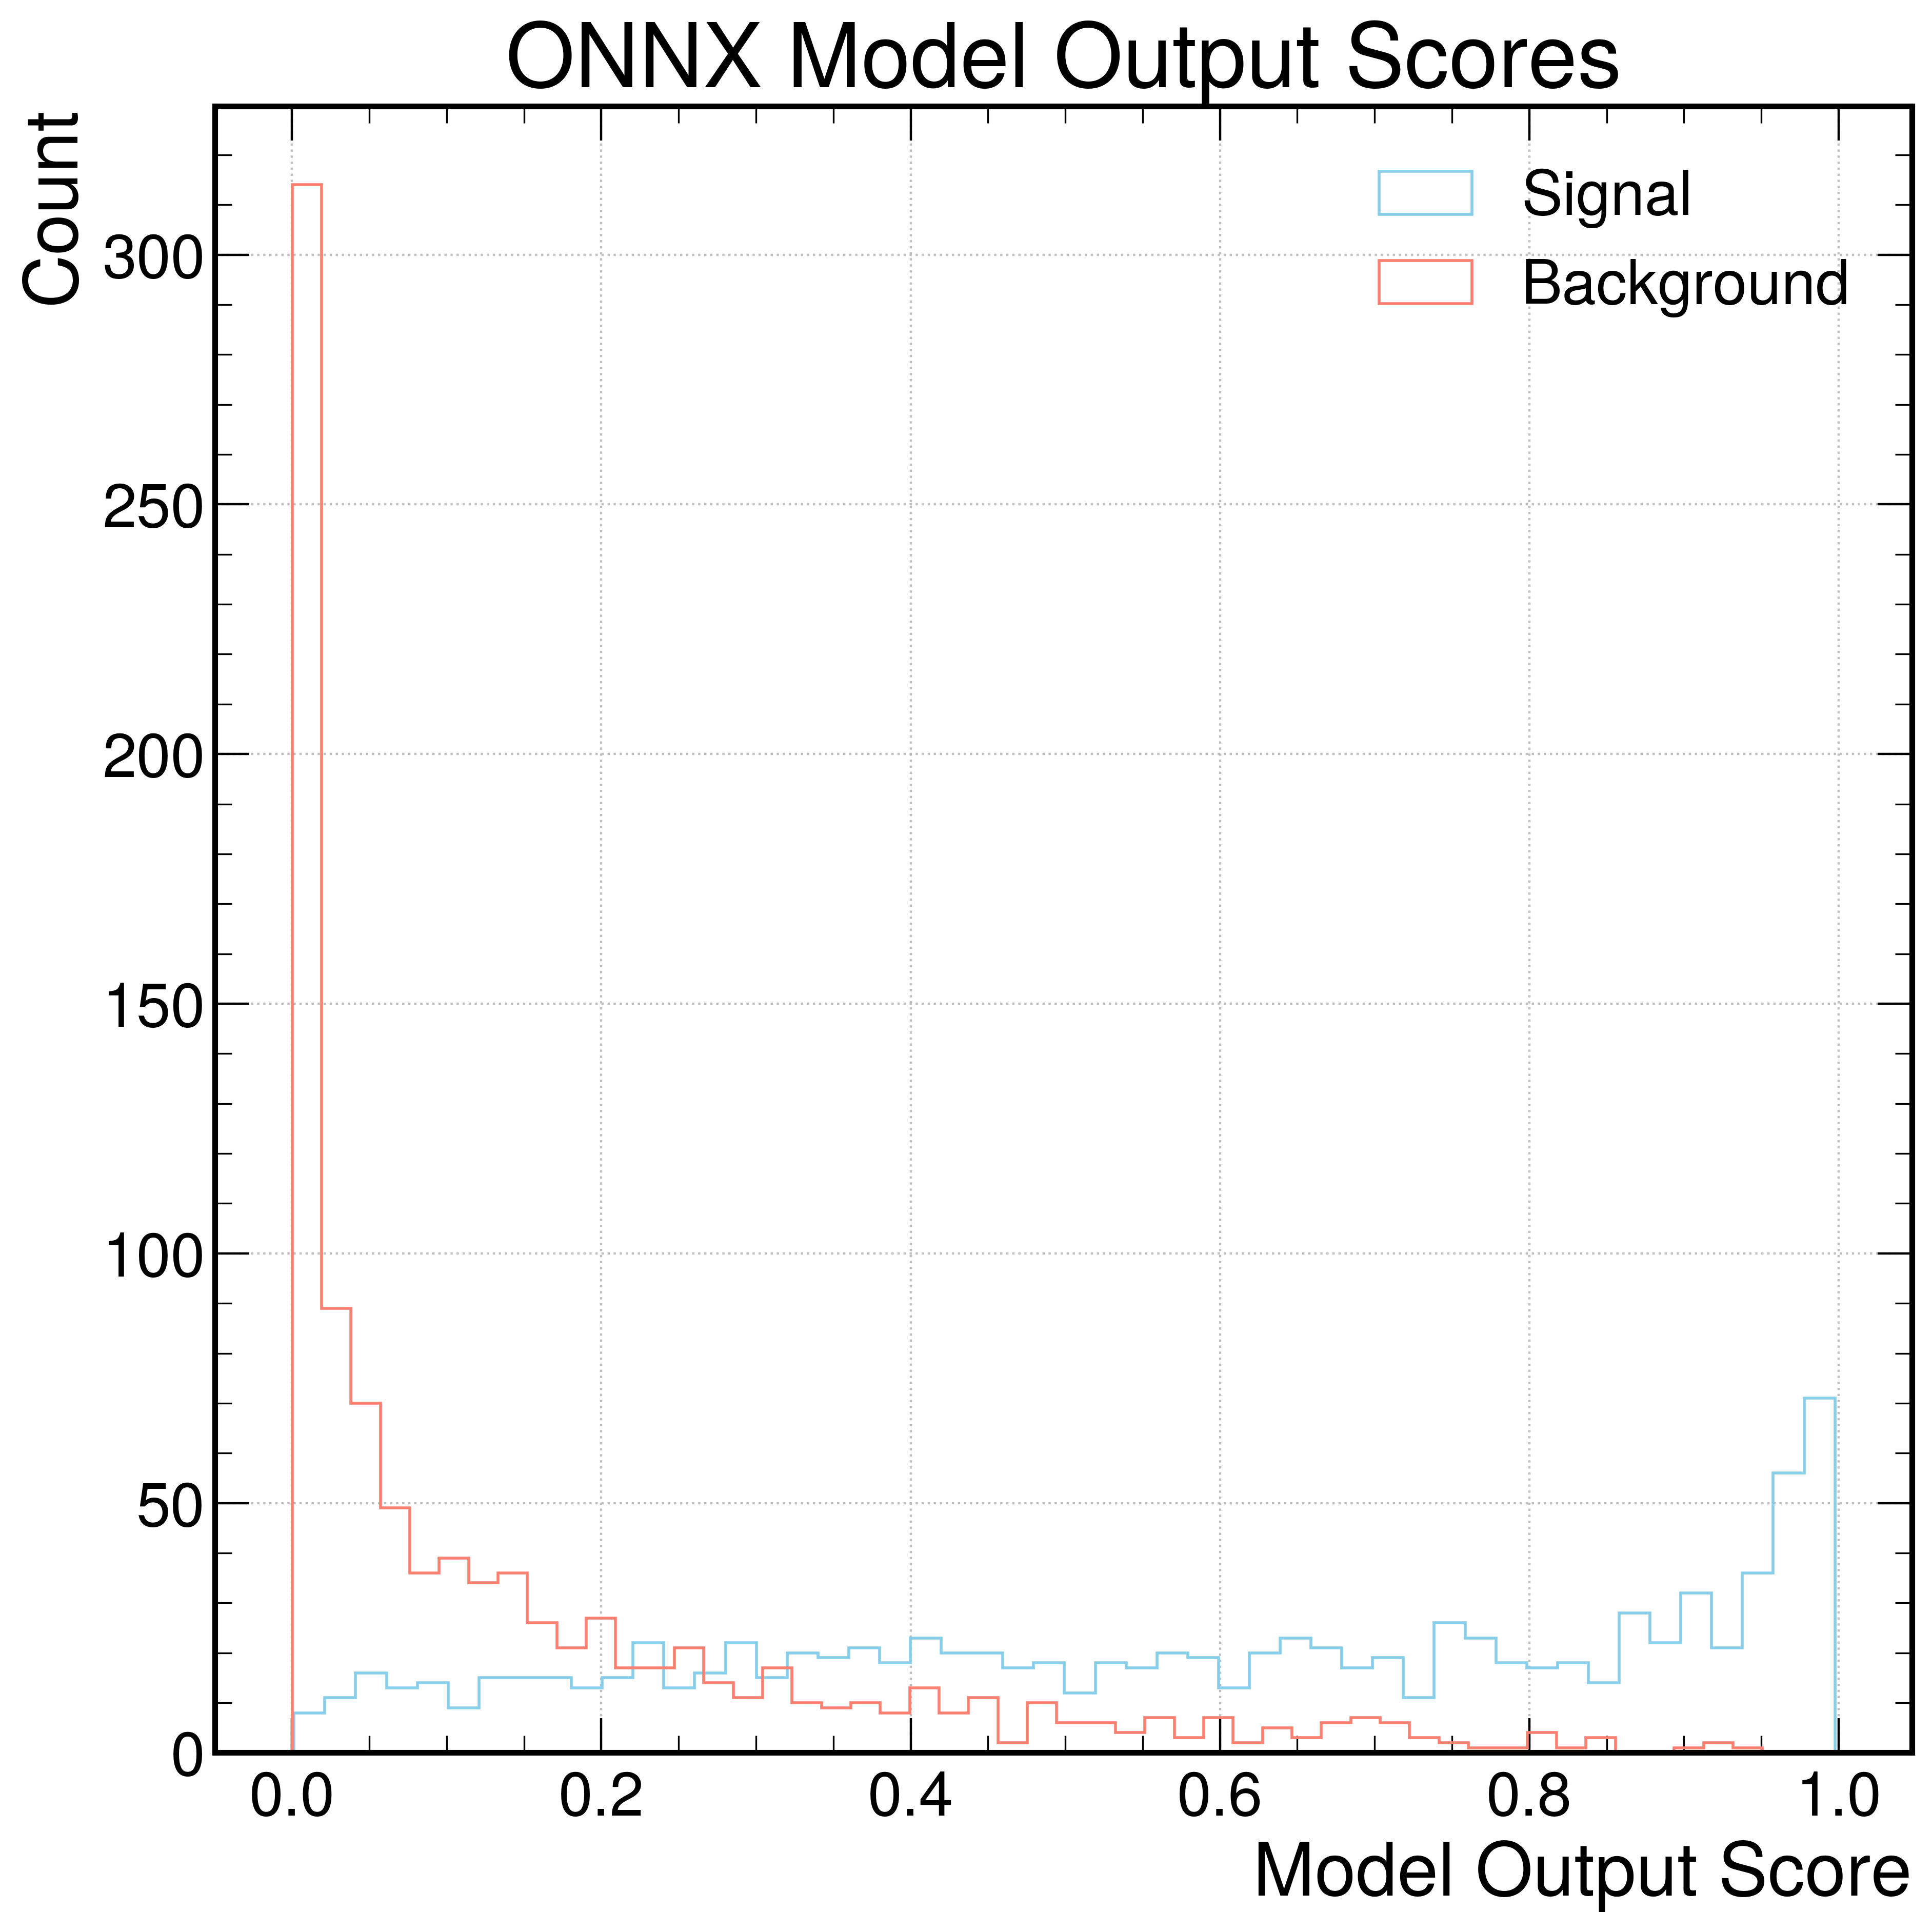

Score distribution plot saved to onnx_model_score_dist.png


In [37]:
plt.figure()
plt.hist(signal_scores, bins=50, color="skyblue", histtype="step", label="Signal")
plt.hist(bkg_scores, bins=50, color="salmon", histtype="step", label="Background")
plt.xlabel("Model Output Score")
plt.ylabel("Count")
plt.title("ONNX Model Output Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.gca().set_yscale("log")
plt.savefig("onnx_model_score_dist.png")
plt.show()
print("Score distribution plot saved to onnx_model_score_dist.png")

In [66]:
# Load all three models
even_sess = ort.InferenceSession("even_model_simplified.onnx")
odd_sess = ort.InferenceSession("odd_model_simplified.onnx")
model_sess = ort.InferenceSession("./outputs/model.onnx")

output_names_even = [o.name for o in even_sess.get_outputs()]
output_names_odd = [o.name for o in odd_sess.get_outputs()]
model_input_name = model_sess.get_inputs()[0].name
model_output_names = [o.name for o in model_sess.get_outputs()]

# Prepare input dicts for transformer models
signal_inputs = build_onnx_input_dict_batch(signal_sample)
bkg_inputs = build_onnx_input_dict_batch(bkg_sample)

# Get predictions from even/odd models
signal_even = even_sess.run(output_names_even, signal_inputs)[0]
signal_odd = odd_sess.run(output_names_odd, signal_inputs)[0]
bkg_even = even_sess.run(output_names_even, bkg_inputs)[0]
bkg_odd = odd_sess.run(output_names_odd, bkg_inputs)[0]

if signal_even.ndim == 2 and signal_even.shape[1] == 2:
    signal_even = signal_even[:, 1]
    signal_odd = signal_odd[:, 1]
    bkg_even = bkg_even[:, 1]
    bkg_odd = bkg_odd[:, 1]

# Average even/odd scores
signal_transformer_scores = (signal_even + signal_odd) / 2
bkg_transformer_scores = (bkg_even + bkg_odd) / 2

# Use all columns except target/weight/event_no for xgb model
model_feature_cols = [col for col in df.columns if col not in ["HH", "bkg", "weight", "event_no"]]
print(len(model_feature_cols))  # Should be 64

model_signal_input = signal_sample[model_feature_cols].values.astype(np.float32)
model_bkg_input = bkg_sample[model_feature_cols].values.astype(np.float32)

# Prepare input for xgb model (flat features)
# Use the correct feature set for model.onnx
model_signal_input = signal_sample[model_feature_cols].values.astype(np.float32)
model_bkg_input = bkg_sample[model_feature_cols].values.astype(np.float32)

xgb_signal_scores = model_sess.run(model_output_names, {model_input_name: model_signal_input})[0]
xgb_bkg_scores = model_sess.run(model_output_names, {model_input_name: model_bkg_input})[0]

if xgb_signal_scores.ndim == 2 and xgb_signal_scores.shape[1] == 2:
    xgb_signal_scores = xgb_signal_scores[:, 1]
    xgb_bkg_scores = xgb_bkg_scores[:, 1]

# Final ensemble: average all three models
ensemble_signal_scores = (signal_transformer_scores + xgb_signal_scores) / 2
ensemble_bkg_scores = (bkg_transformer_scores + xgb_bkg_scores) / 2

ensemble_signal_scores = ensemble_signal_scores.flatten()
ensemble_bkg_scores = ensemble_bkg_scores.flatten()

64


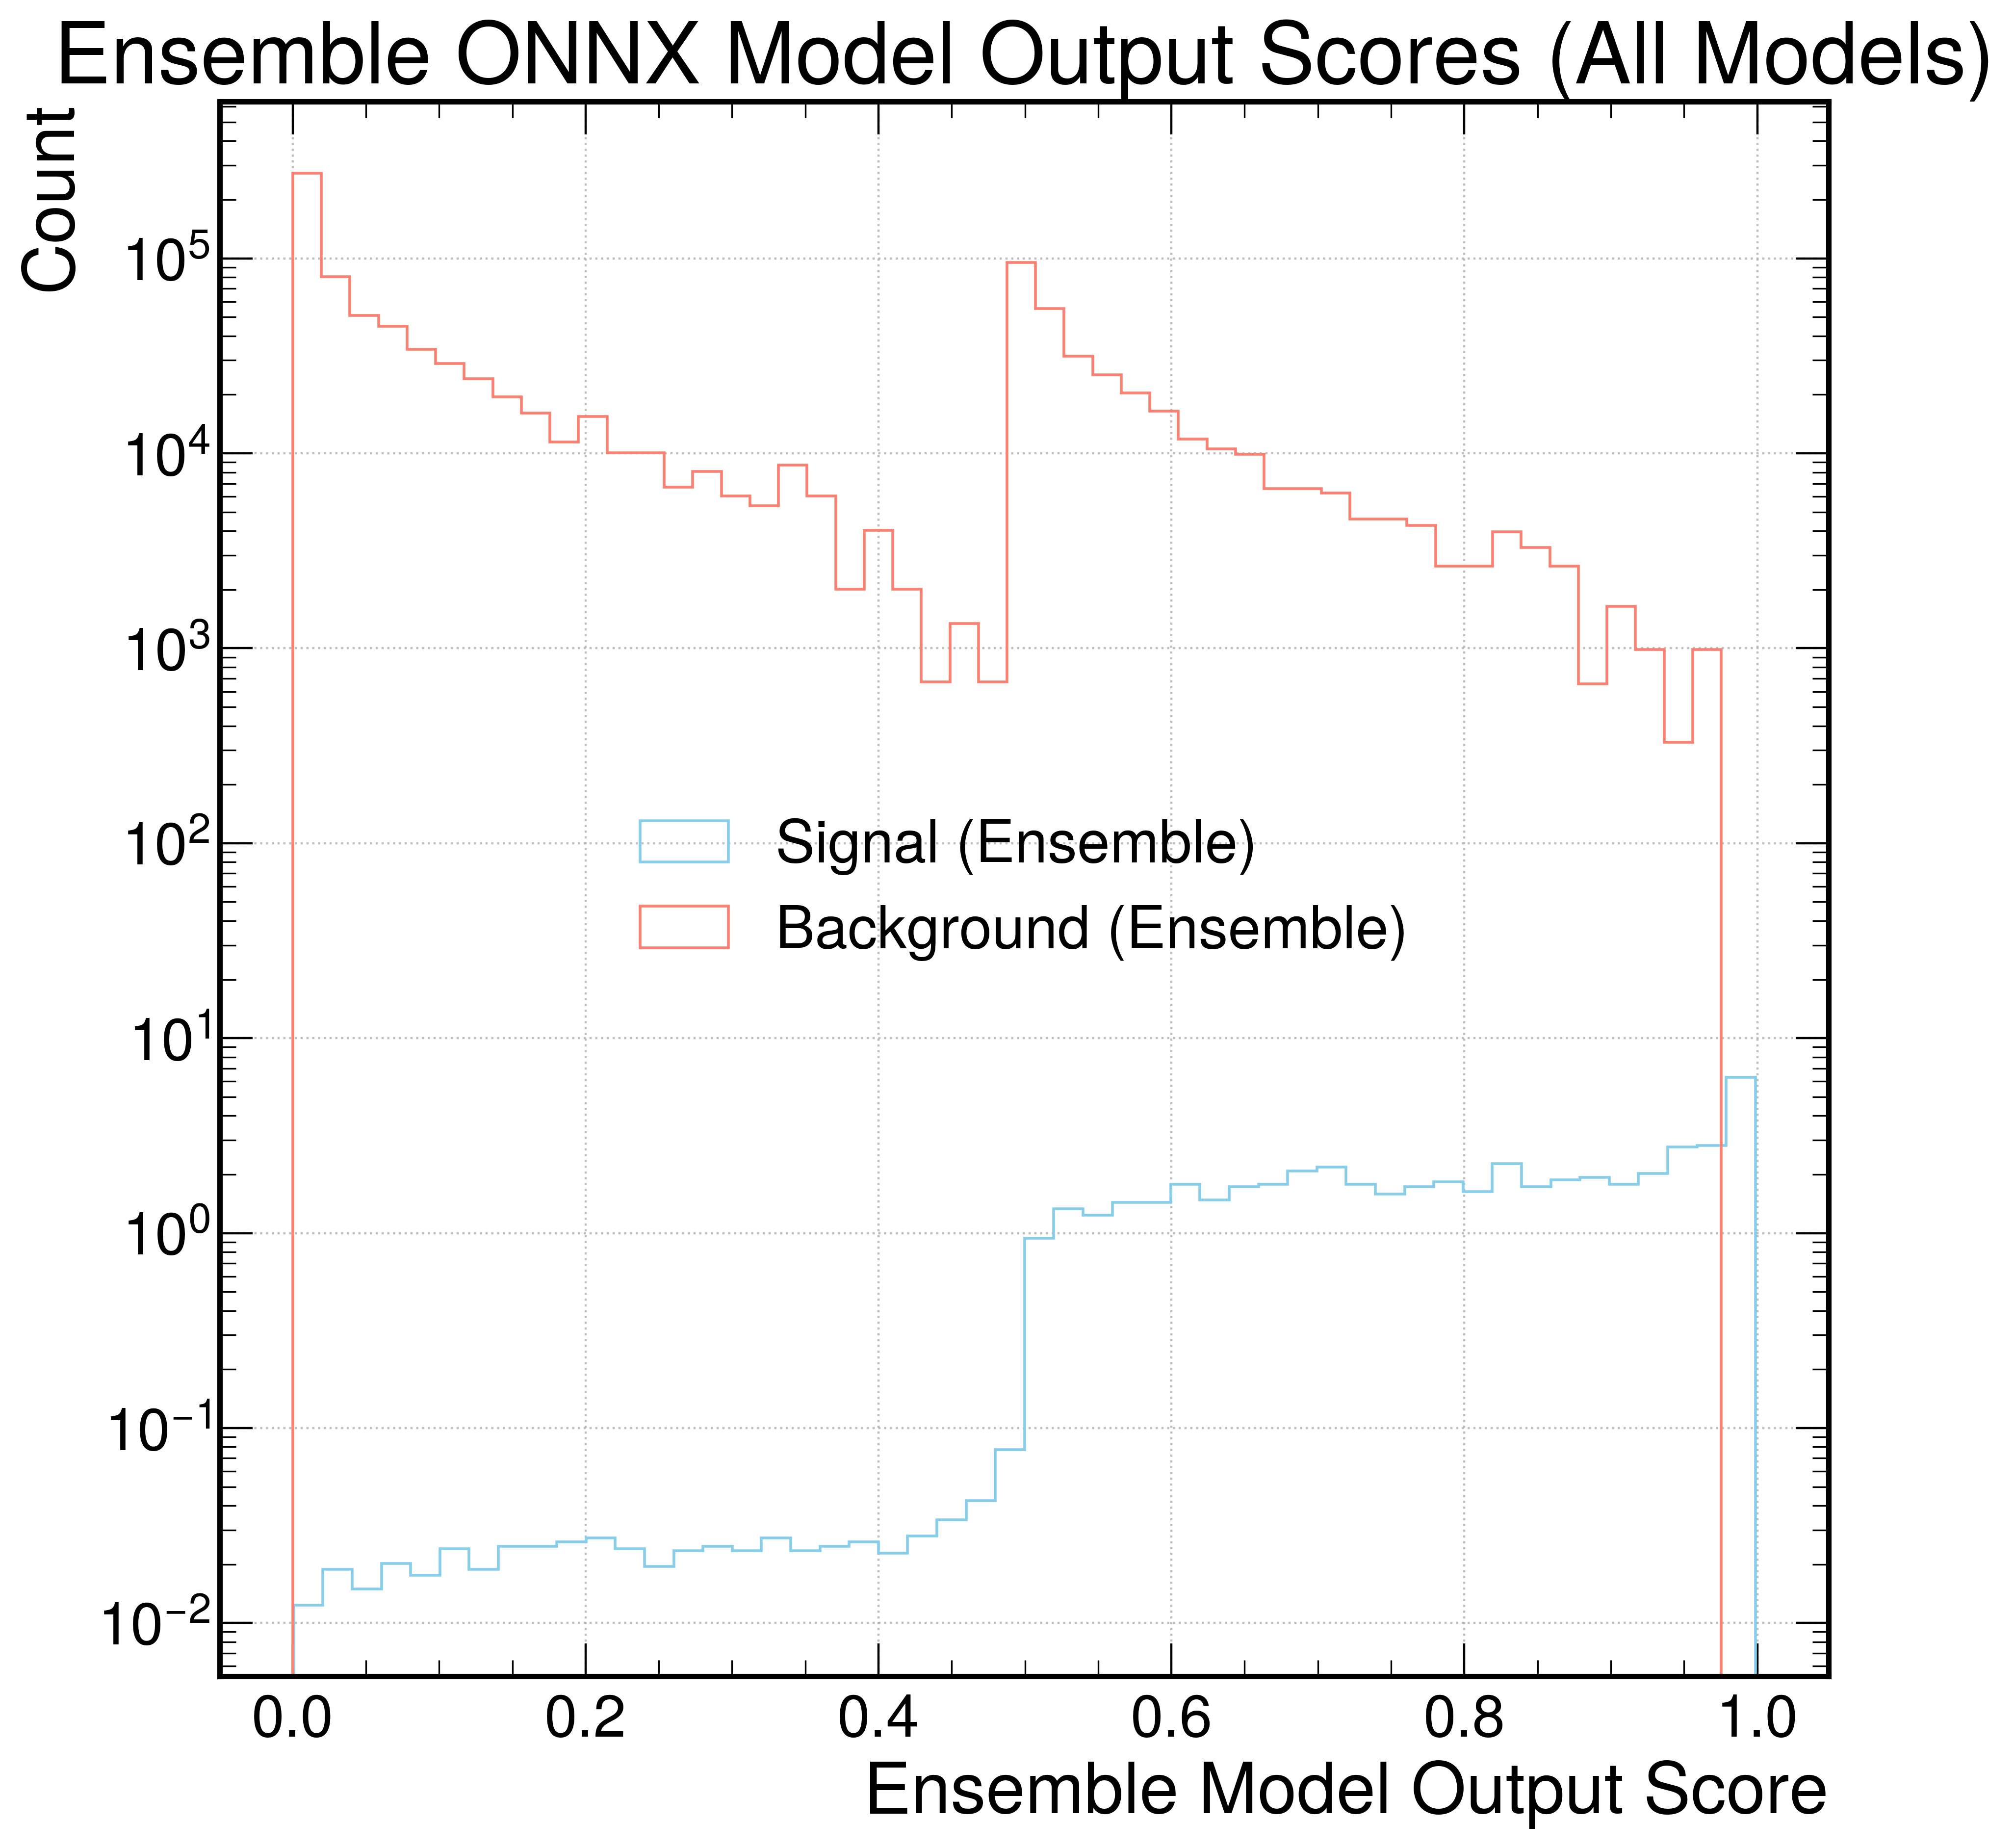

Ensemble score distribution plot saved to ensemble_onnx_model_score_dist_all.png


In [67]:
# Plot ensemble scores
plt.figure()
plt.hist(ensemble_signal_scores, bins=50, color="skyblue", histtype="step", label="Signal (Ensemble)", density=True)
plt.hist(ensemble_bkg_scores, bins=50, color="salmon", histtype="step", label="Background (Ensemble)", density=False)
plt.xlabel("Ensemble Model Output Score")
plt.ylabel("Count")
plt.title("Ensemble ONNX Model Output Scores (All Models)")
plt.legend()
plt.gca().set_yscale("log")
plt.grid(True)
plt.tight_layout()
plt.savefig("ensemble_onnx_model_score_dist_all.png")
plt.show()
print("Ensemble score distribution plot saved to ensemble_onnx_model_score_dist_all.png")